# Time Series Forecast

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [5]:
aep_df = pd.read_csv('AEP_hourly.csv')
aep_df = aep_df.set_index('Datetime')
aep_df.index = pd.to_datetime(aep_df.index)

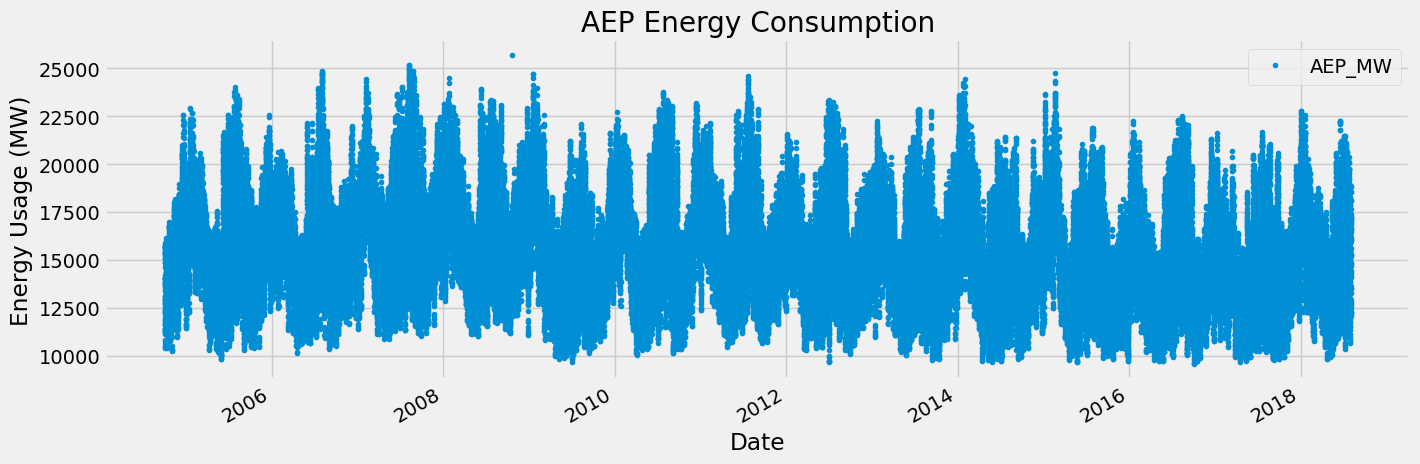

In [6]:
aep_df.plot(style='.',
            figsize=(15, 5),
            title='AEP Energy Consumption')
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.show()

### Train/Test Split

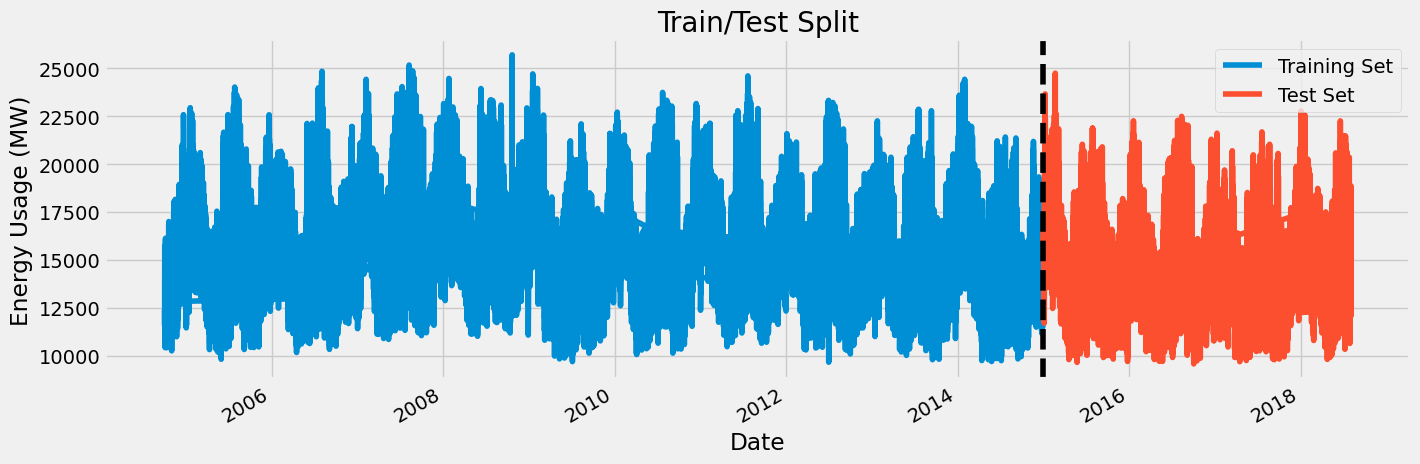

In [7]:
train = aep_df.loc[aep_df.index < '2015-01-01']
test = aep_df.loc[aep_df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
plt.title('Train/Test Split')
plt.ylabel('Energy Usage (MW)')
plt.xlabel('Date')
plt.legend(['Training Set', 'Test Set'])
plt.axvline(x='2015-01-01', color='black', ls='--')
plt.show()

### Feature Creation

In [8]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    return df

df=create_features(aep_df)

### Visualize Feature/Target Relationships

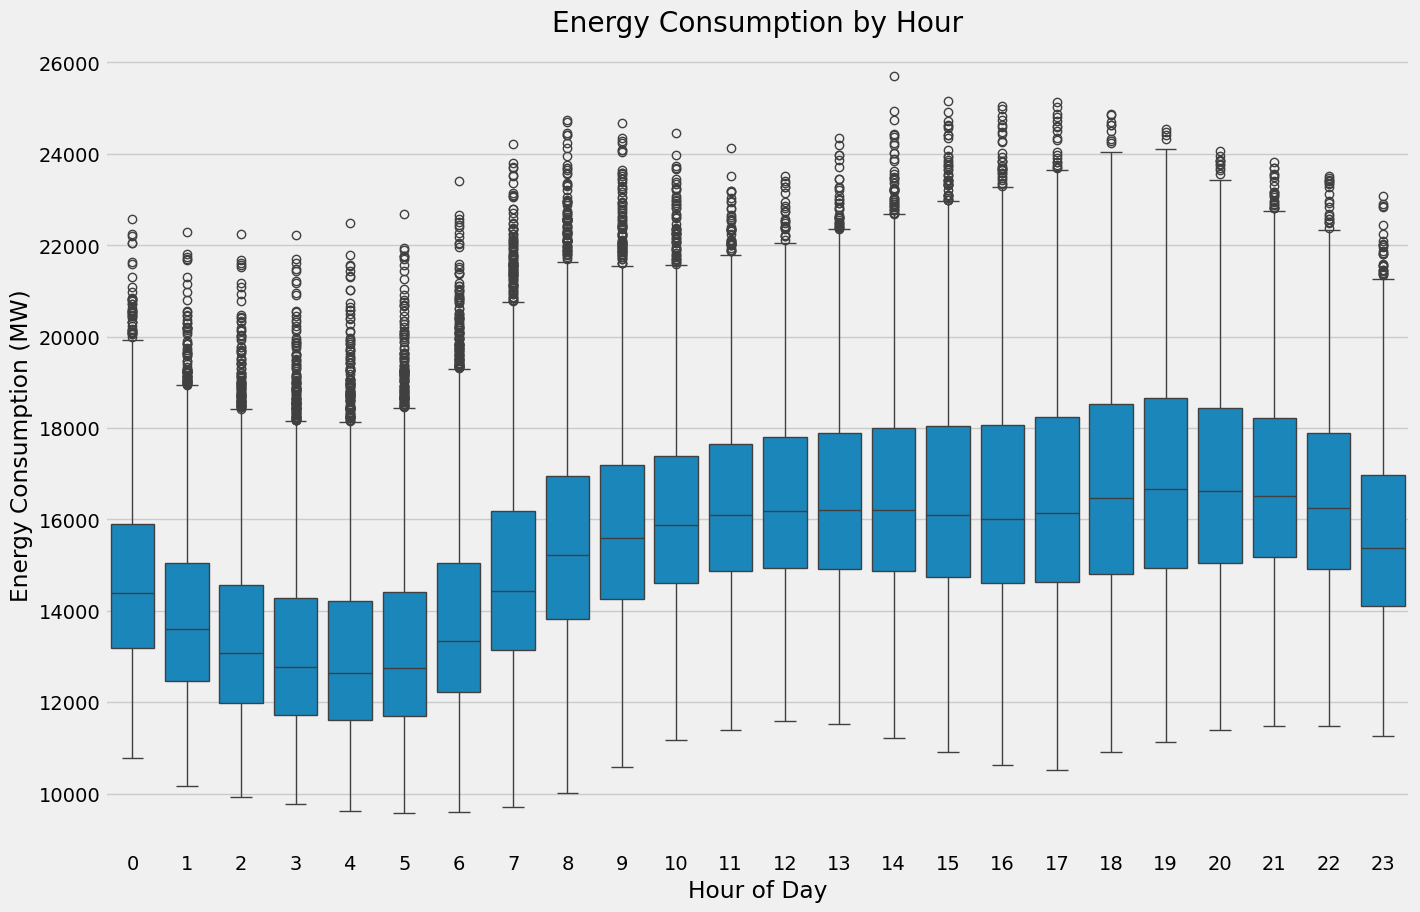

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df, x='hour', y='AEP_MW')
plt.title('Energy Consumption by Hour')
plt.ylabel('Energy Consumption (MW)')
plt.xlabel('Hour of Day')
plt.show()

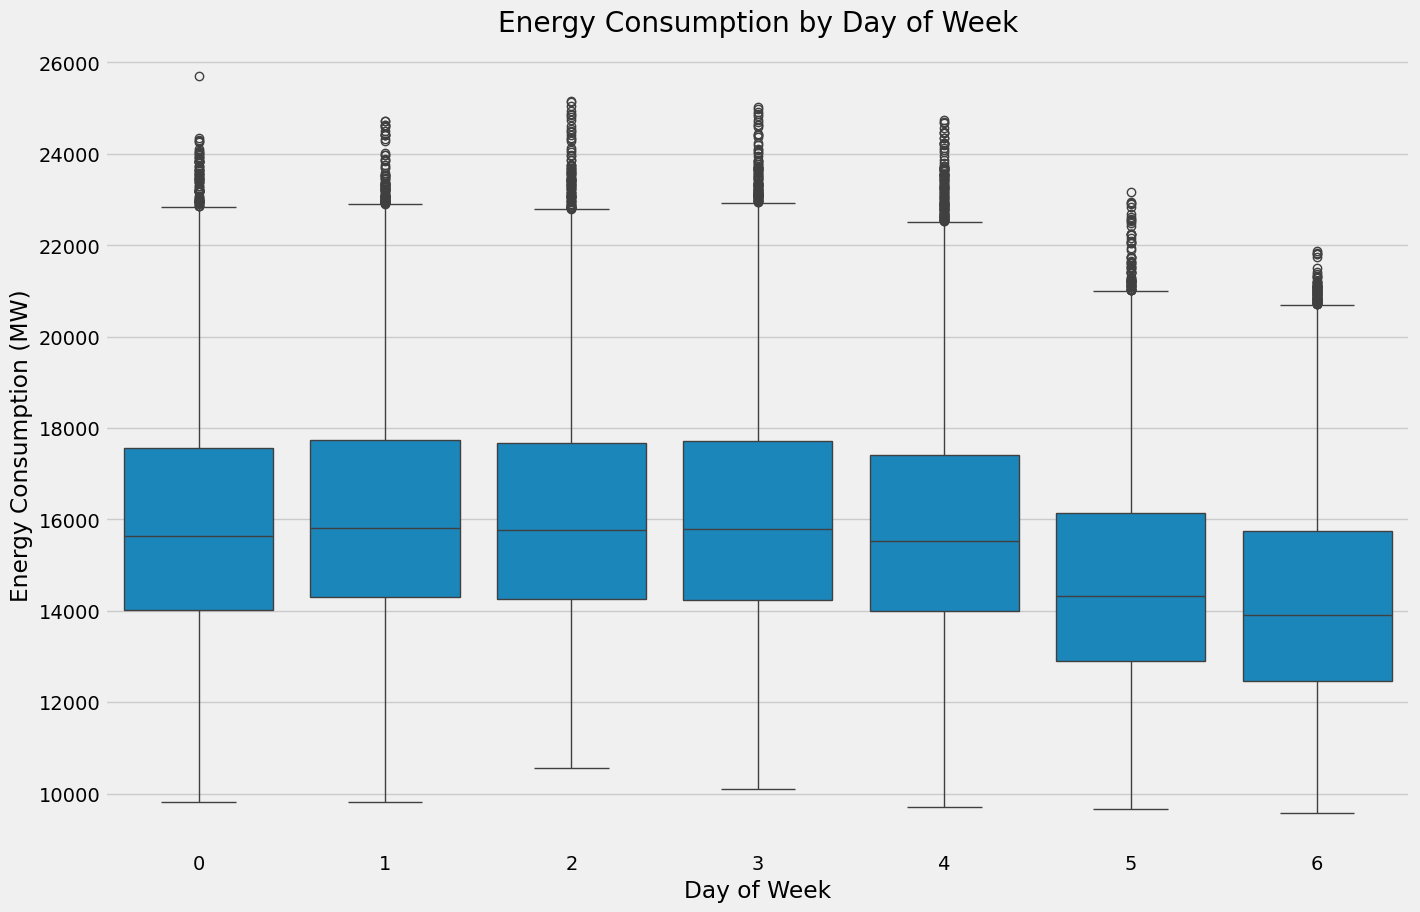

In [10]:
fig,ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df, x='day_of_week', y='AEP_MW')
plt.title('Energy Consumption by Day of Week')
plt.ylabel('Energy Consumption (MW)')
plt.xlabel('Day of Week')
plt.show()

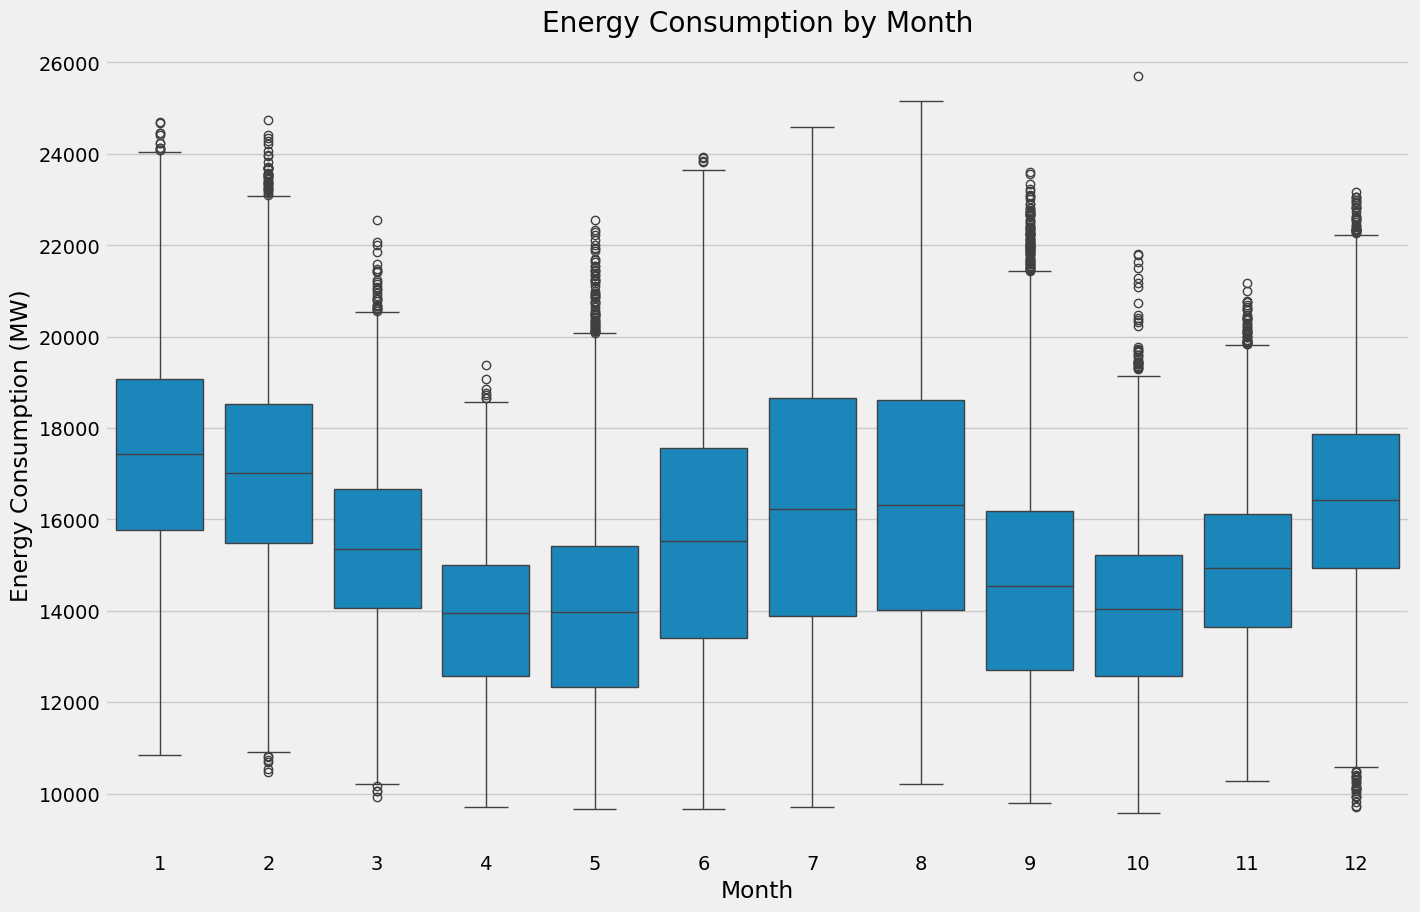

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=df, x='month', y='AEP_MW')
plt.title('Energy Consumption by Month')
plt.ylabel('Energy Consumption (MW)')
plt.xlabel('Month')
plt.show()

### Model Creation

In [12]:
train = create_features(train)
test = create_features(test)

features = ['hour','day_of_week','month','day_of_month','quarter','year','day_of_year','week_of_year']
target = 'AEP_MW'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [13]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2557.08360	validation_1-rmse:2669.83182
[100]	validation_0-rmse:1664.41207	validation_1-rmse:1911.45680
[200]	validation_0-rmse:1380.53110	validation_1-rmse:1733.84462
[300]	validation_0-rmse:1251.33068	validation_1-rmse:1680.77859
[400]	validation_0-rmse:1159.76326	validation_1-rmse:1657.38702
[500]	validation_0-rmse:1099.65693	validation_1-rmse:1644.49847
[579]	validation_0-rmse:1062.56186	validation_1-rmse:1650.05537


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### Feature Importance

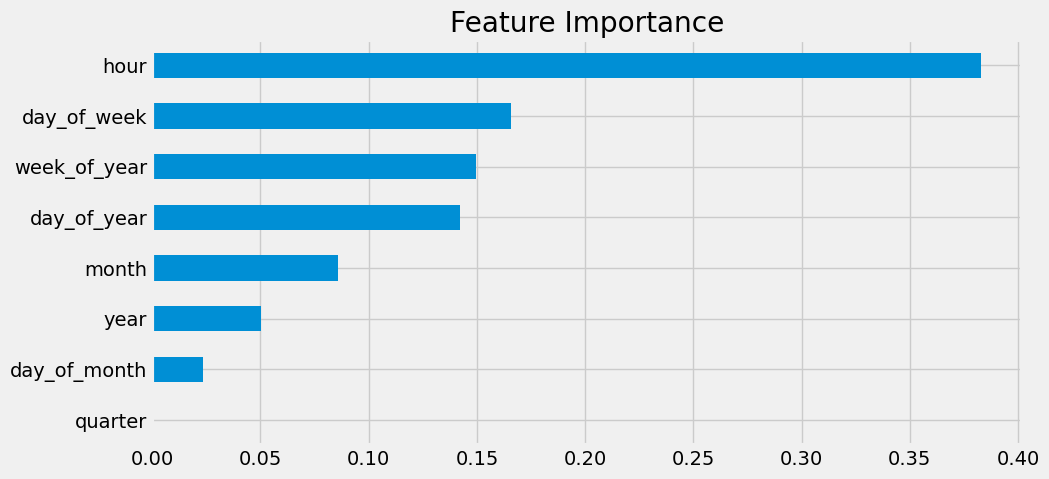

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', 
                                  figsize=(10,5), 
                                  title='Feature Importance',
                                  legend=False)
plt.show()

### Forecast on Test

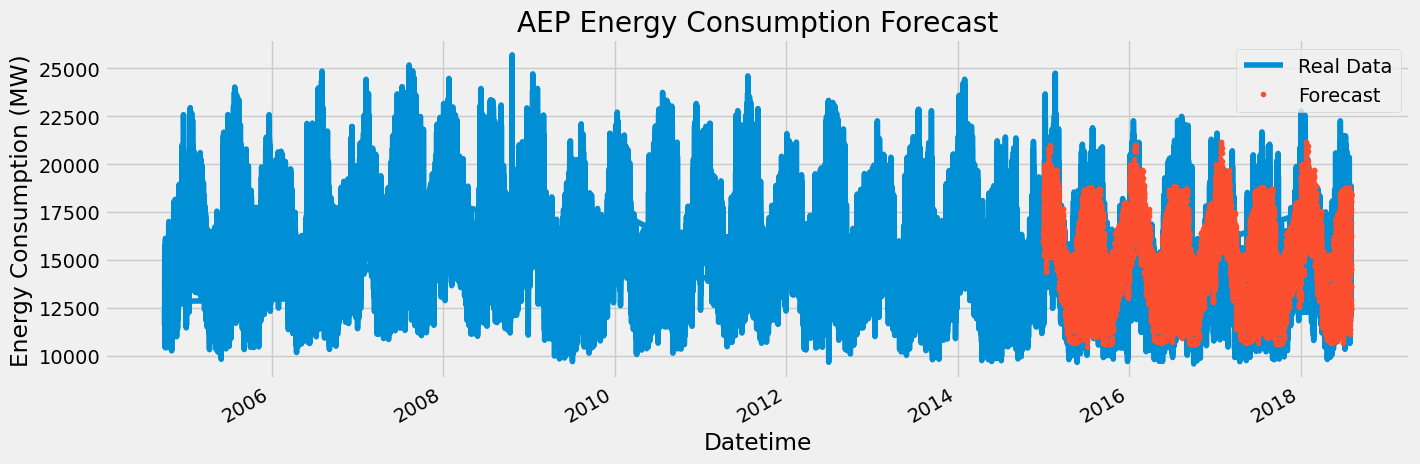

In [15]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = df[['AEP_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
ax.set_title('AEP Energy Consumption Forecast')
ax.set_ylabel('Energy Consumption (MW)')
plt.legend(['Real Data','Forecast'])
plt.show()

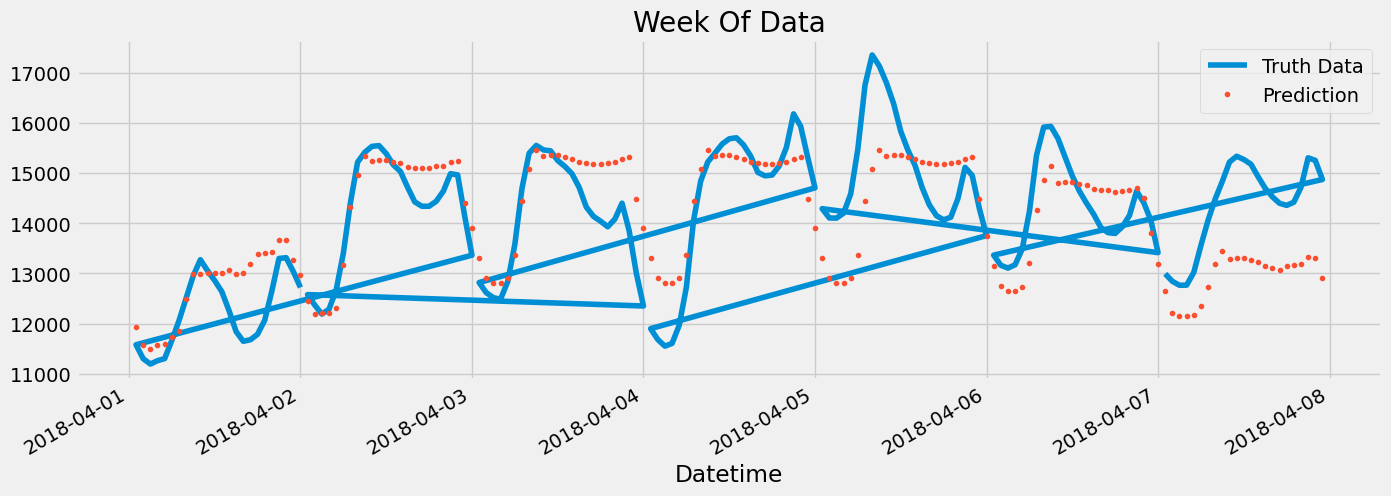

In [16]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

### Score (RMSE)

In [17]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test Set: {score:.2f}')

RMSE Score on Test Set: 1643.09


### Calculate Error

In [18]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-20    5030.130452
2015-02-19    4805.768473
2017-01-22    4530.739909
2017-01-23    4527.361084
2017-01-25    4482.491130
2017-02-24    4470.903239
2018-01-22    4407.598633
2017-02-23    4343.232747
2018-01-23    4260.204915
2017-01-24    4193.933350
Name: error, dtype: float64

### Key Takeaways